#  Прогнозирование заказов такси / Taxi order forecasting

Собраны исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час, построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Этапы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Historical data on taxi orders at airports has been collected. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour and build a model for such a prediction.

The *RMSE* metric value on the test sample should be no more than 48.

Stages:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.

## Подготовка / Preparation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/vladamalkina/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
print(data.index.is_monotonic)
data.isna().sum()

True


num_orders    0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Ресемплирование данных по одному часу: / Resampling data one hour at a time:

In [5]:
data = data.resample('1H').sum()

## Анализ / Анализ

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data)

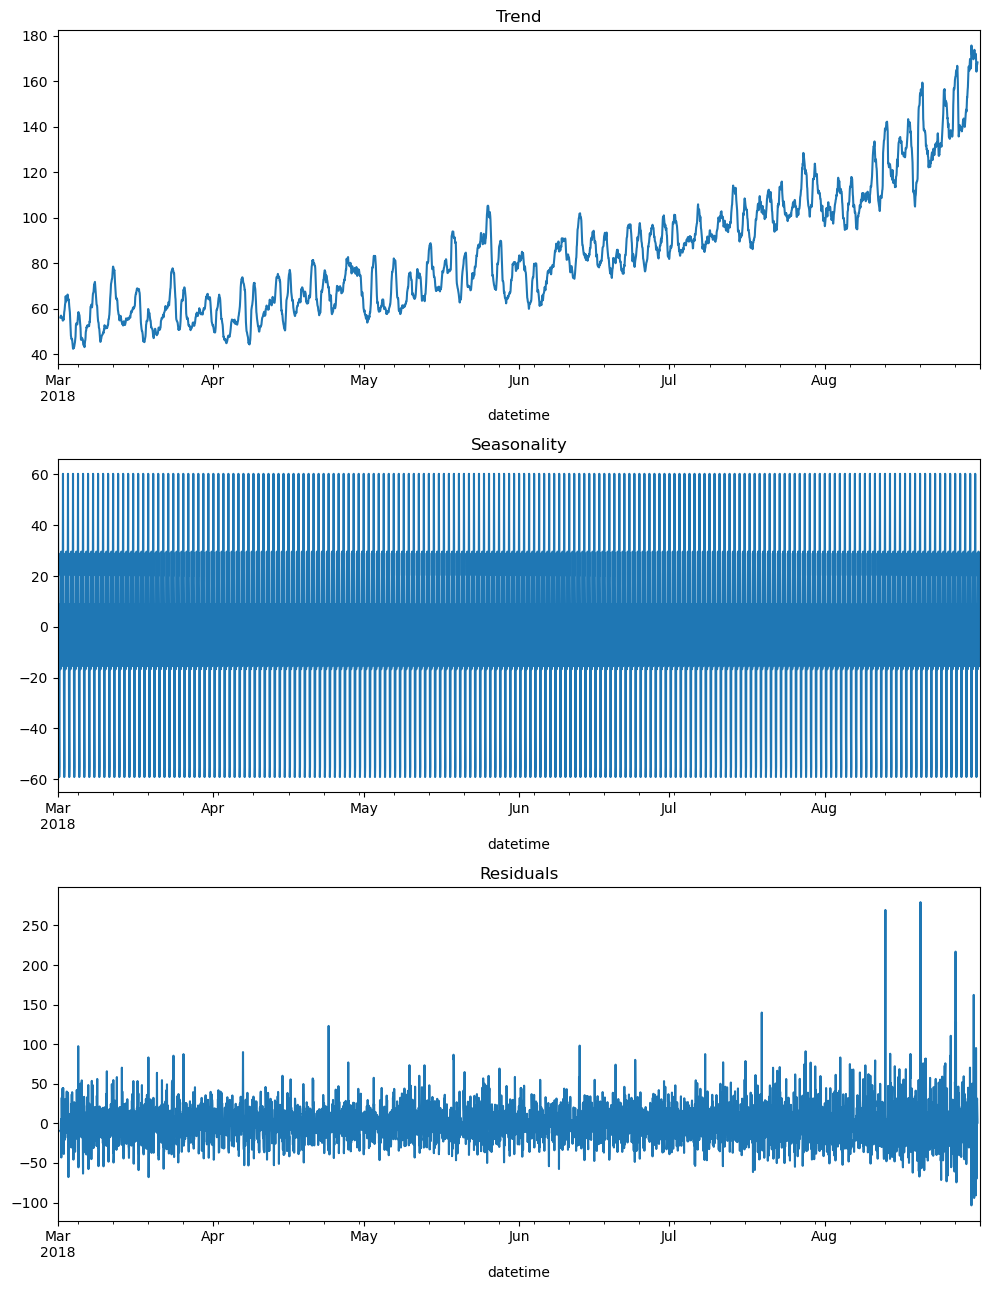

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 13))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

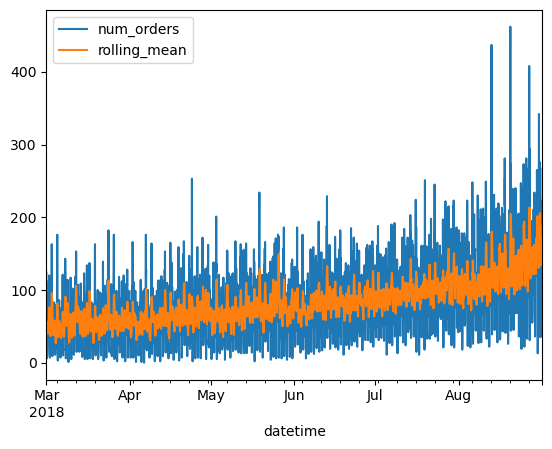

In [8]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot()

Создание признаков для временных рядов: / Creating features for time series:

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['dayofweek'] = data.index.dayofweek
        data['hour'] = data.index.hour
        
        for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [10]:
make_features(data, 1, 24)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4392 non-null   float64
 2   dayofweek     4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   lag_1         4415 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 207.0 KB


Разобьем данные на обучающую и тестовую выборки(90%:10%):

Let's split the data into training and test samples (90%:10%):

In [11]:
train, test = train_test_split(data,  test_size = 0.1, random_state = 12345, shuffle=False)
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

## Обучение / Education

LINEAR REGRESSION

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
model = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', abs(cross_val_score(model,train_features, train_target, 
                         cv = TimeSeriesSplit(n_splits=20), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()))

Значение метрики RMSE на обучающей выборке для LinearRegression 30.762581006695648


CATBOOST

In [13]:
parameters = {'depth': range(1, 5, 1),
              'learning_rate': np.arange(0.00, 0.15, 0.05),
              'iterations':  range(0, 10, 5)}

In [14]:
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(CatBoostRegressor(), param_grid = parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch.fit(train_features, train_target)
abs(gsearch.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
0:	learn: 36.9907725	total: 56.8ms	remaining: 227ms
1:	learn: 35.6392357	total: 62.4ms	remaining: 93.6ms
2:	learn: 34.5527061	total: 63ms	remaining: 42ms
3:	learn: 33.3609582	total: 63.5ms	remaining: 15.9ms
4:	learn: 32.5367075	total: 64.1ms	remaining: 0us


34.504844330188156

СЛУЧАЙНЫЙ ЛЕС / RANDOM FOREST

In [15]:
from sklearn.ensemble import RandomForestRegressor
parameters = { 'n_estimators': range (1, 20, 1),
              'max_depth': range (1, 20, 1)}

In [16]:
tscv = TimeSeriesSplit(n_splits=8)
gsearch_tree = GridSearchCV(RandomForestRegressor(), param_grid = parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch_tree.fit(train_features, train_target)
abs(gsearch_tree.best_score_)

Fitting 8 folds for each of 361 candidates, totalling 2888 fits


24.984896989549544

RMSE LINEAR REGRESSION = 30.762581006695648

RMSE CATBOOST = 34.504844330188156

RMSE RANDOM FOREST = 24.984896989549544

Best model - RANDOM FOREST

## Тестирование / Testing

In [17]:
pred_test = gsearch_tree.predict(test_features)
print(mean_squared_error(pred_test, test_target)**0.5)

46.19802822970237


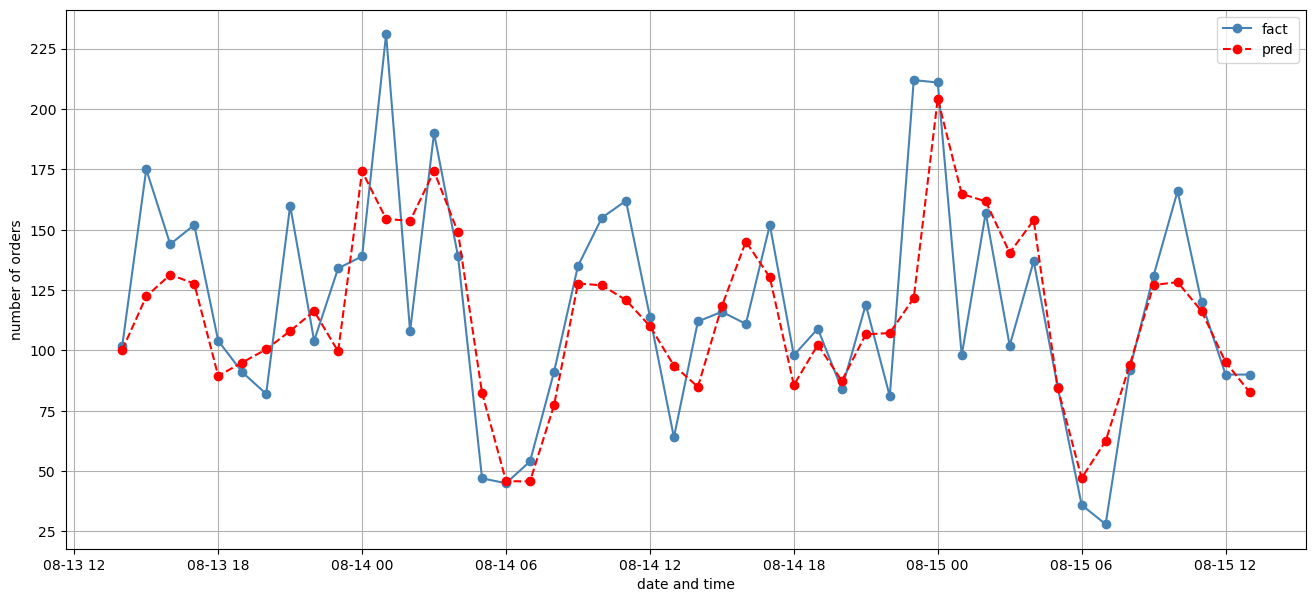

In [18]:
actual_ = test_target[0:48]
pferict_data = pd.DataFrame(pred_test[0:48], index = actual_.index)
plt.figure(figsize=(16, 7))
plt.plot(actual_, 'ro', color = 'steelblue', linestyle = '-', label = 'fact')
plt.plot(pferict_data, 'ro', color = 'r', linestyle = '--', label = 'pred')
plt.legend()
plt.xlabel('date and time')
plt.ylabel('number of orders')
plt.grid(True)
plt.show()